## Pseudolikelihood (finally)

I'm using the same convention as conIII -- we use upper triangular matrices, the first N elements are the local fields (we set them to 0), the other N(N-1)/2 are the elements of the matrix, going left to right. This is an important convention because otherwise calc_corr_obs is only compatible with this. 

In [3]:
import numpy as np
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.optimize import minimize

In [4]:
from clean_data import voting_data as samples
samples = np.array(samples)

In [5]:
%matplotlib inline

In [6]:
def plot_heatmap(J):
    J_ = J.reshape((9,9))
    cm = sns.diverging_palette(248, 12, sep=1, n=256)
    sns.heatmap(J_, cmap=cm, vmin=-1, vmax=1)

In [7]:
def calc_obs_r(r, samples):
    """ This functions populates a matrix with the same shape as the samples (num_samples x num_
    dimensions) with the value s_r * s_j for every data sample. s_j is in order from least to 
    greatest. """
    N = len(samples[0])
    
    obs = np.zeros(np.shape(samples))
    
    
    for rowix in range(len(samples)):
        obs[rowix, 0] = samples[rowix, r]
        ixcount = 1
        for i in range(N - 1):
            for j in range(i + 1, N):
                if i == r or j == r:
                    obs[rowix, ixcount] = samples[rowix, i] * samples[rowix, j]
                    ixcount += 1
    return(obs)

In [8]:
def utr_idx(N, i, j):
    """ Do not question this function. It converts square indices to flat k=1 upper triangular
    indices. """
    if i == j: raise(ValueError("i and j cannot be equal"))
    elif i < j: return (2 * N + 1-i) * i//2 + j - i - (i +1)
    else: return utr_idx(N, j, i)

def calc_jij_r(r, J, N):
    """ Returns a vector of J_rj from an upper triangular k = 1 matrix of J. The upper triangular k = 1
    matrix is equal to np.concatenate([np.diag(J), Jsquare[np.triu(len(Jsquare), k=1)]]). Choosing this
    so I can compare it to conIII if need be. """
    if len(J) != N*(N+1) / 2: raise ValueError("J should be a vector of concatenated local fields and" +
                                               " upper triangular elements.")
    all_other_elements = [i for i in range(N) if i != r]
    r_ind = np.sort([utr_idx(N, r, j) for j in all_other_elements]) + N
    jr_ind = np.concatenate(([r],r_ind))
    return([J[jr_ind], jr_ind])
    

In [9]:
def minimizer_func(params, samples):
    """ Params is the normal concatenation of h and Jij """
    loglikelihood = 0
    N = len(samples[0])
    dloglikelihood = np.zeros_like(params)
    
    for r in range(N):
        obs = calc_obs_r(r, samples)
        jr_vector, jr_ind = calc_jij_r(r, params, N)
        E = -obs.dot(jr_vector)
        loglikelihood += -np.log(1 + np.exp(2 * E)).sum()
        dloglikelihood[jr_ind] += ( -(1/(1+np.exp(2*E)) * np.exp(2*E))[:,None] * 2*obs ).sum(0)
    return(-loglikelihood, dloglikelihood)

In [10]:
def solve_for_jij(samples):
    N = len(samples[0])
    initial_guess = np.zeros(int(N * (N+1) / 2))
    soln = minimize(minimizer_func, initial_guess, jac=True, args=(samples))
    return(soln.x)

In [11]:
mysol = solve_for_jij(samples)

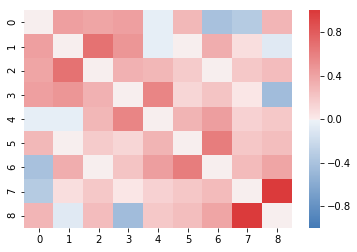

In [12]:
plot_heatmap(squareform(mysol[9:]))